In [13]:
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt

imsize = 400

# Load and resize the content image
content = cv2.imread("./images/house 2-small.jpg")
content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB)
content = content[0:imsize, 0:imsize]

# Load and resize the style image
style = cv2.imread("./images/starry-night - small.jpg")
style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB)
style = style[0:imsize, 0:imsize]


In [15]:
# Define a function for style transfer (you need to implement this function)
def style_transfer(content, style,hallucinated , mask, hallcoeff, wcoeff, patch_sizes, scales, imsize):
    
        # Initialize variables
    C0 = content.reshape(-1)
    S0 = style.reshape(-1)

    # One-dimensional image
    sigma_s = 5
    sigma_r = 0.2
    h0 = imsize
    w0 = imsize
    c = 3

    # Convert to 3D arrays
    C0 = C0.reshape(h0, w0, c)
    S0 = S0.reshape(h0, w0, c)

    # Initialize C to color palette of S using histogram matching
    for channel in range(c):
        C0[:, :, channel] = exposure.match_histograms(C0[:, :, channel], S0[:, :, channel])
    
    # return C0

    # Reshape C0 to a 1D array
    C0 = C0.reshape(-1)

    gap_sizes = [28, 18, 9, 6]
    X = C0
    X = X + np.max(X) * np.random.randn(X.size)  # Add large noise at the beginning
    X = X.reshape(-1)
    return hallucinated

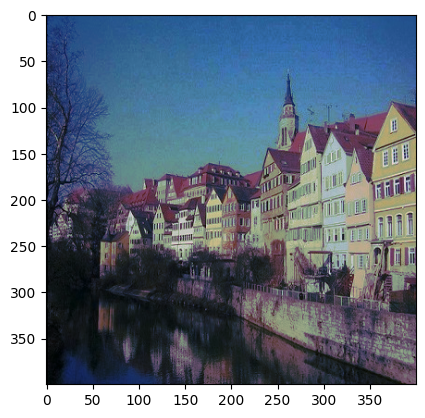

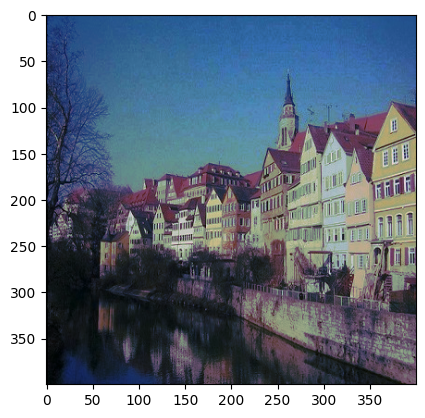

In [17]:
IMG=style_transfer(content, style,0,0,0,0,0,0,imsize)
# PLT THIS IMAGE

plt.imshow(content)
plt.show()


plt.imshow(IMG)
plt.show()